In [135]:
#installations 
!pip install anndata 
!pip install combat
!pip install python-igraph
!pip install louvain
!pip install leidenalg


#imports
import numpy as np
import anndata as ad
import zipfile
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import sklearn
from anndata import read_h5ad
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from combat.pycombat import pycombat #https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_03_integration.html
import warnings
warnings.filterwarnings("ignore")
from matplotlib import rcParams

     |████████████████████████████████| 229 kB 6.8 MB/s eta 0:00:01


In [107]:
#agreed upon paramters across group 
parameters = {
    
              "myeloid" : True, 
              "non_myeloid" : True,
              
              "min_genes" : 250, # 250
              "max_genes" : 6000, # 6000
              "min_transcripts" : 200, # 200
              "max_transcripts" : 1e7, # 30000
              "min_cells" : 3, # how can we also include the mito data less than 30% of the RNA
              
              "highly_variable_genes" : True,
              "target_sum" : 1e4,
              "min_mean" : 0.0125, # 0.0125
              "max_mean" : 3, # 3
              "min_disp" : 0.2, # 0.5
              
              "highly_varied_genes" : False,
              "keep_percent_genes" : 0.5,
              
              "cell_classes" : None, # None for all or choose from ["neuron", "macrophage", "endothelial cell", "brain pericyte", "astrocyte", "microglial cell", "oligodendrocyte"]
              
              "mutual_information": False,
              "mutual_info_num" : 0.05,
              "mutual_info_path" : "aging_genes",
              
              "train_test_split" : 0.3,
              
              "compute_raw" : False,
              
              "compute_normalize" : False, # Set False if you want PCA or highly variable gene!
              
              "compute_PCA" : False,
              "num_PCA_components" : 10,
             }

# Uploading Tabula Muris and Lee Rubin Aging Dataset(s) & Preprocessing

In [108]:
#for loading Tabula Muris Senis data!

def scRNA_dataset(dir_, **kwargs):
    
    print("Loading the data...")
    
    brain = sc.read_h5ad(dir_)
    brain.var_names_make_unique()
    pd.set_option('display.max_rows', None)
    
    print("Average number of UMI:, ", np.mean(brain.X.sum(axis=1)))
    print("Average nonzero genes: ", np.mean((brain.X != 0).sum(axis=1)))
    
    if kwargs["myeloid"] and kwargs["non_myeloid"]:
        brain_datasets = ["Brain_Non-Myeloid", "Brain_Myeloid"]
    elif kwargs["myeloid"]:
        brain_datasets = ["Brain_Myeloid"]
    elif kwargs["non_myeloid"]:
        brain_datasets = ["Brain_Non-Myeloid"]
    else:
        print("You need to select True for myeloid and/or non_myeloid...")
        return None, None, None, None, None
    
    brain_data = brain[brain.obs.tissue.isin(brain_datasets)]
    
    print("Data loaded (dimension:", brain_data.shape, ")!")
    
    if (kwargs["highly_variable_genes"] and kwargs["highly_varied_genes"]) or (not kwargs["highly_variable_genes"] and not kwargs["highly_varied_genes"]):
        print("You need to select True for highly_expressed_genes or highly_varied_genes...")
        return None, None, None, None, None
    
    elif kwargs["highly_variable_genes"]:
        print("Highly variable gene selection...")
        brain_data2 = brain_data.copy()
        
        # Total-count normalize the data matrix X to 10,000 reads per cell - counts are comparable among cells
        sc.pp.normalize_total(brain_data2, target_sum = kwargs["target_sum"])

        # Logarithmize the data
        sc.pp.log1p(brain_data2) 

        # Identify highly variable genes 
        sc.pp.highly_variable_genes(brain_data2, min_mean = kwargs["min_mean"], max_mean = kwargs["max_mean"], 
                                    min_disp = kwargs["min_disp"])

        # Filter to keep highly variable
        brain_data = brain_data[:, brain_data2.var.highly_variable] 
        
        print("Data size after highly variable gene selection (normalize + log + highly variable):", brain_data.shape, ")!")

    elif kwargs["highly_varied_genes"]:
        # Compute normalized variance of data and keep the max n_top_genes 
        print("Highly varied gene selection...")
        sc.pp.highly_variable_genes(brain_data, flavor = "seurat_v3", n_top_genes = int(brain_data.var_names.shape[0]*kwargs["keep_percent_genes"]))
    
    print("Removing cells and genes...")

    # Remove cells with too many or too little expressed genes
    brain_data = brain_data[brain_data.obs.n_genes > kwargs["min_genes"], :]
    print("min genes: ", brain_data.shape)
    brain_data = brain_data[brain_data.obs.n_genes < kwargs["max_genes"], :]
    print("max genes: ", brain_data.shape)
    
    # Remove cells with too many or too little transcript genes
    brain_data = brain_data[brain_data.obs.n_counts < kwargs["max_transcripts"], :]
    print("max transcripts: ", brain_data.shape)
    brain_data = brain_data[brain_data.obs.n_counts > kwargs["min_transcripts"], :]
    print("min transcripts: ", brain_data.shape)
    
    # Remove genes only present in less than Y cells
    sc.pp.filter_genes(brain_data, min_cells = kwargs["min_cells"]) 
    print("filter min cells: ", brain_data.shape)
    
    print("Data size after removing cells and genes that are too high/low expressed:", brain_data.shape, ")!")
    
    brain_data_pd = pd.DataFrame(brain_data.X.toarray(), columns = brain_data.var.index.tolist(), index = brain_data.obs.cell.tolist())
    age_label_pd = brain_data.obs.age
    
    # Selecting specific cell types
    cell_classes = brain_data.obs.cell_ontology_class.unique()
    if kwargs["cell_classes"]:
        
        print("Selecting different cell types...")
        for cell_class in kwargs["cell_classes"]:
            if cell_class not in cell_classes:
                print("This cell type was not found:", cell_class)
                print("Choose from:", cell_classes)
                return None, None, None, None, None
        if len(kwargs["cell_classes"]) > 1:
            cell_indxs = np.logical_or([np.array(brain_data.obs.cell_ontology_class == name) for name in kwargs["cell_classes"]])
        else:
            cell_indxs = np.array(brain_data.obs.cell_ontology_class == kwargs["cell_classes"][0])
            
        brain_data_pd = brain_data_pd[cell_indxs]
        age_label_pd = age_label_pd[cell_indxs]
        
    # More dimension reduction via gene selection
    if kwargs["mutual_information"]:
        print("Running mutual information...")
        try:
            gene_names = np.load(kwargs["mutual_info_path"])
            important_genes = []
            
            for gene in brain_data.var_names:
                if gene in gene_names:
                    important_genes.append(True)
                else:
                    important_genes.append(False)
            
            brain_data_pd = brain_data_pd[brain_data_pd.columns[important_genes]]
                    
        except:
            brain_data_norm = (brain_data_pd - brain_data_pd.mean()) / brain_data_pd.std()
            mutual_info = MIC(brain_data_norm, age_label_pd)

            important_genes = mutual_info>kwargs["mutual_info_num"]
            gene_names = brain_data.var_names[important_genes]
            
            np.save(kwargs["mutual_info_path"], gene_names)
            
            brain_data_pd = brain_data_pd[brain_data_pd.columns[important_genes]]
        
    # Returning the training testing
    X_train, X_test, y_train, y_test = train_test_split(brain_data_pd, age_label_pd, test_size=kwargs["train_test_split"], random_state=42)
    
    if kwargs["compute_raw"]:  
        print("Returning raw data!")
        return brain_data, X_train, X_test, y_train, y_test
    else:
        X_train, X_test  = X_train.T, X_test.T
        X_train = (X_train - X_train.mean()) / X_train.std()
        X_test = (X_test - X_test.mean()) / X_test.std()       
        X_train, X_test  = X_train.T, X_test.T         

        if kwargs["compute_normalize"]:  
            print("Returning normalized data!")
            return brain_data, X_train, X_test, y_train, y_test

        elif kwargs["compute_PCA"]: 
            print("Returning PCA components!")
            pca = PCA(n_components=kwargs["num_PCA_components"])
            pca.fit(X_train)
            columns = ['pca_%i' % i for i in range(1, kwargs["num_PCA_components"]+1)]
            X_train = pd.DataFrame(pca.transform(X_train), columns=columns, index=X_train.index)
            X_test = pd.DataFrame(pca.transform(X_test), columns=columns, index=X_test.index)

            return brain_data, X_train, X_test, y_train, y_test

        else:
            print("Returning normalized data (woot)!")
            return brain_data, X_train, X_test, y_train, y_test
        
brain_data, X_train, X_test, y_train, y_test = scRNA_dataset("/Users/kathrinkajderowicz/Downloads/tabula-muris-senis-facs-official-raw-obj.h5ad", **parameters)

Loading the data...
Average number of UMI:,  1168853.9
Average nonzero genes:  2647.7953331408357
Data loaded (dimension: (20666, 22966) )!
Highly variable gene selection...
Data size after highly variable gene selection (normalize + log + highly variable): (20666, 9347) )!
Removing cells and genes...
min genes:  (20666, 9347)
max genes:  (20553, 9347)
max transcripts:  (20400, 9347)
min transcripts:  (20400, 9347)
filter min cells:  (20400, 9347)
Data size after removing cells and genes that are too high/low expressed: (20400, 9347) )!
Returning normalized data (woot)!


In [109]:
# Upload Lee Rubin Brain aging - data 
import zipfile
zip = zipfile.ZipFile('/Users/kathrinkajderowicz/Downloads/expression.txt.zip')
data = zip.extractall()
data = pd.read_csv('expression.txt', delimiter = '\t', chunksize = 1000)
pd_df = pd.concat(data)

# Getting the gene into the rows and cells into the columns

pd_df.index = pd_df['GENE']
pd_df.drop('GENE', axis=1, inplace=True)
pd_df = pd_df.T
pd_df.head()

GENE                                              Sox17    Mrpl15  Lypla1  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG    0.0  1.340271     0.0   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA    0.0  0.000000     0.0   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT    0.0  0.000000     0.0   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT    0.0  0.000000     0.0   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA    0.0  0.000000     0.0   

GENE                                              Tcea1  Rgs20  Atp6v1h  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG    0.0    0.0      0.0   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA    0.0    0.0      0.0   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT    0.0    0.0      0.0   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT    0.0    0.0      0.0   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA    0.0    0.0      0.0   

GENE                                              Oprk1  Rb1cc1  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG    0.0     0.0   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA    0.0     0.0   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT    0.0     0.0   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT    0.0     0.0   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA    0.0     0.0   

GENE                                              4732440D04Rik  St18  ...  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG            0.0   0.0  ...   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA            0.0   0.0  ...   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT            0.0   0.0  ...   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT            0.0   0.0  ...   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA            0.0   0.0  ...   

GENE                                                mt-Nd3   mt-Nd4l  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG  1.340271  1.340271   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA  0.000000  1.986951   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT  2.929314  0.000000   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT  1.549226  0.000000   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA  0.000000  0.000000   

GENE                                                mt-Nd4    mt-Nd5  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG  2.507998  0.000000   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA  3.480204  0.000000   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT  4.589359  0.000000   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT  3.423043  1.549226   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA  0.000000  0.000000   

GENE                                                mt-Nd6   mt-Cytb  Vamp7  \
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG  0.000000  3.374196    0.0   
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA  0.000000  4.337542    0.0   
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT  0.000000  4.589359    0.0   
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT  1.549226  2.972418    0.0   
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA  0.000000  0.000000    0.0   

GENE                                              AC168977.1  PISD  DHRSX  
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG         0.0   0.0    0.0  
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA         0.0   0.0    0.0  
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT         0.0   0.0    0.0  
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT         0.0   0.0    0.0  
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA         0.0   0.0    0.0  

[5 rows x 14699 columns]

In [110]:
# Checking if the columns have been normalized
list_cells = ['Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG', 'Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA', 'Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT']
pd_df_exp = np.exp(pd_df)-1
pd_df_exp.head()
for count, cell in enumerate(list_cells):
    print(pd_df_exp.iloc[count].sum()) # the data has be pre normalized to 1e4 and then the log was taken

10000.000000000016
10000.000000000011
9999.999999999989


In [111]:
# Transforming Lee Rubin data into an ANNdata format: 

rubin_data = ad.AnnData(X=pd_df.iloc[:,:])
rubin_data.var = pd.DataFrame(pd_df.columns.to_list(), columns=['gene'])
rubin_data.obs = pd.DataFrame(pd_df.index.to_list(), columns=['cell'])

ad.AnnData.write_h5ad(rubin_data, "rubin_data.h5ad")
rubin_data = sc.read_h5ad("rubin_data.h5ad")

In [112]:
# Uploading metadata for Lee Rubin data sets
meta = pd.read_csv("/Users/kathrinkajderowicz/Downloads/meta_Aging_mouse_brain_portal_data.txt", delimiter="\t")
meta.drop(0, axis=0, inplace=True)
rubin_data.obs['cell_type'] = meta['cell_type'].tolist()
rubin_data.obs['cell_type_by_age'] = meta['cell_type_by_age'].tolist()
rubin_data.obs['cell_class'] = meta['cell_class'].tolist()
rubin_data.obs['cell_class_by_age'] = meta['cell_class_by_age'].tolist()
rubin_data.obs['all_cells_by_age'] = meta['all_cells_by_age'].tolist()
rubin_data.obs['nGene'] = meta['nGene'].tolist()
rubin_data.obs['nUMI'] = meta['nUMI'].tolist()

In [113]:
# Need to filter the features to make sure that they are identical in the two datasets
gene_overlap = brain_data.var.index.intersection(rubin_data.var['gene'])
print("There is an overlap of ", gene_overlap.size, " of the two datasets. \n The Tabula Muris Senis had ", brain_data.var.size, " genes, and the Rubin dataset had ", rubin_data.var.size, " genes.")

There is an overlap of  8051  of the two datasets. 
 The Tabula Muris Senis had  9347  genes, and the Rubin dataset had  14699  genes.


In [114]:
# Final datasets for each with overlapped genes
rubin_data.var_names = rubin_data.var['gene']
rubin_data_overlap = rubin_data[:, rubin_data.var_names.isin(gene_overlap.to_list())]
brain_data_overlap = brain_data[:, brain_data.var_names.isin(gene_overlap.to_list())]

In [115]:
# Ccomparison of the clustering, we put together the following markers for the different cell types
cell_markers = pd.read_excel('/Users/kathrinkajderowicz/Downloads/cell_types_5_7_22.xls')
cell_markers.head()

astrocyte brain pericyte macrophage microglial cell neuron endothelial  \
0      Gja1          Kcnj8        Pf4         Tmem119   Syt1        Cd31   
1      Gfap         Pdgfrb      Cd11b            C1qb   NeuN         Kdr   
2      Aqp4            Sma       Cd14            C1qa   Map2      Vegfr2   
3       Clu          Cd146       Cd68           Csf1r  Psd95         Vwf   
4   Aldh1l1           Cd13       Cd64            Ctss  Gap43         NaN   

  oligodendrocyte  
0          Cldn11  
1           Itpr2  
2           Sox10  
3             Mog  
4             Mbp

# Visual exploration of both datasets

         Falling back to preprocessing with `sc.pp.pca` and default params.


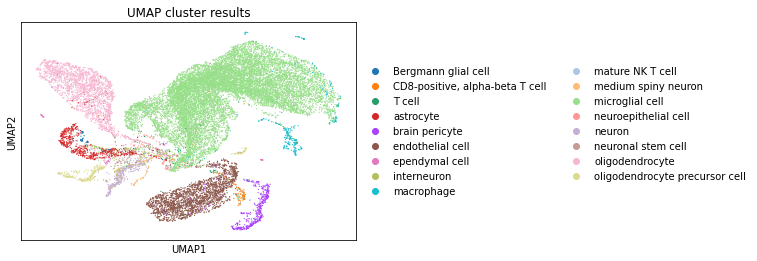

In [116]:
# Visually exploring the Tabula Muris dataset
sc.pp.neighbors(brain_data_overlap, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(brain_data_overlap)
sc.pl.umap(brain_data_overlap, color = 'cell_ontology_class', title = 'UMAP cluster results')

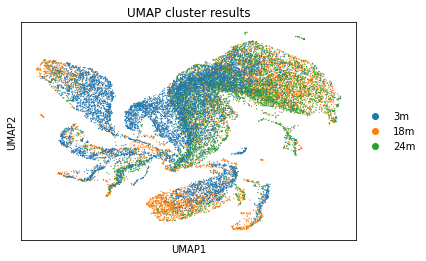

In [117]:
sc.pp.neighbors(brain_data_overlap, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(brain_data_overlap)
sc.pl.umap(brain_data_overlap, color = 'age', title = 'UMAP cluster results')

         Falling back to preprocessing with `sc.pp.pca` and default params.


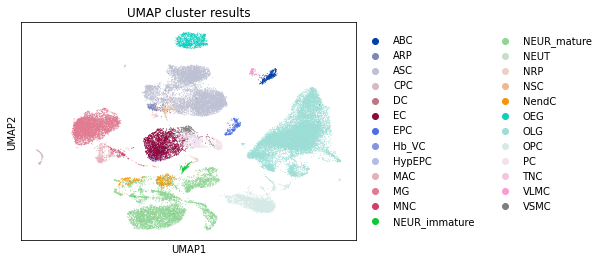

In [118]:
sc.pp.neighbors(rubin_data_overlap, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(rubin_data_overlap)
sc.pl.umap(rubin_data_overlap, color = 'cell_type', title = 'UMAP cluster results')

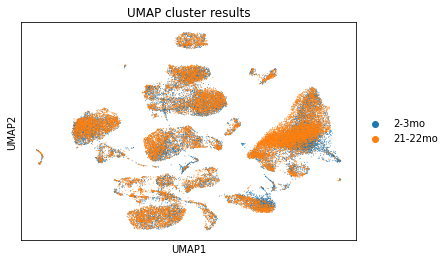

In [119]:
sc.tl.umap(rubin_data_overlap)
sc.pl.umap(rubin_data_overlap, color = 'all_cells_by_age', title = 'UMAP cluster results')

In [120]:
# The cell types that are shared between the two
cell_overlap_rubin = ['OPC', 'OLG', 'NSC', 'ASC', 'mNEUR', 'PC', 'MG', 'MAC']
cell_overlap_TMS = ['oligodendrocyte', 'astrocyte', 'neuron', 'brain pericyte', 'endothelial', ...
                    , 'microglial cell', 'macrophage']

In [121]:
# only keeping the cell types that are in the two datasets
rubin_data_overlap = rubin_data_overlap[rubin_data_overlap.obs['cell_type'].isin(cell_overlap_rubin), :]
brain_data_overlap = brain_data_overlap[brain_data_overlap.obs['cell_ontology_class'].isin(cell_overlap_TMS), :]
# mapping the names of the Rubin dataset into the names of the TMS cell types
rubin_data_overlap.obs['cell_type'] = rubin_data_overlap.obs['cell_type'].map({'OLG': 'oligodendrocyte', 'ASC': 'astrocyte', 'NEUR_mature':'neuron', 'PC': 'brain pericyte', 'MG': 'microglial cell', 'MAC': 'macrophage', 'EC': 'endothelial cell'})

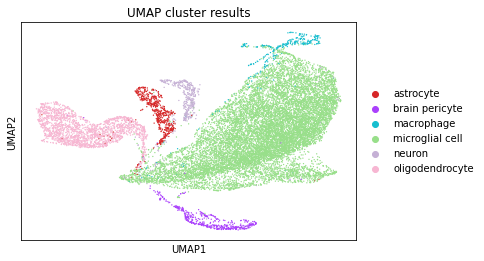

In [131]:
# For the TMS dataset - replotting only with the overlapping cells
#sc.tl.louvain(brain_data_overlap)
sc.pp.neighbors(brain_data_overlap, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(brain_data_overlap)
sc.pl.umap(brain_data_overlap, color = 'cell_ontology_class', title = 'UMAP cluster results')

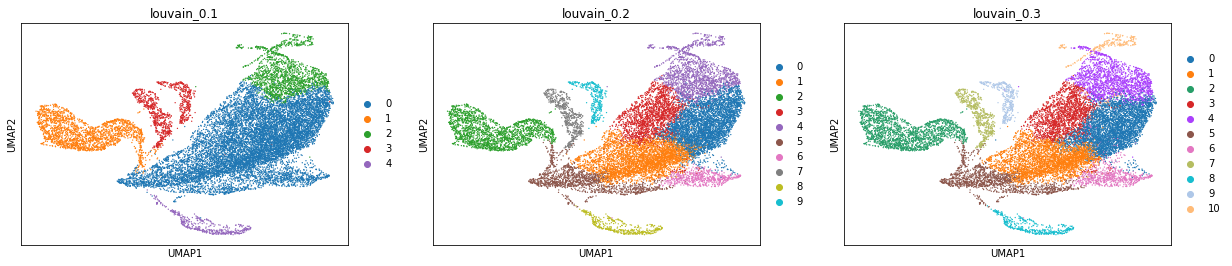

In [137]:
#trying louvain
sc.tl.louvain(brain_data_overlap, resolution = 0.1, key_added = "louvain_0.1")
sc.tl.louvain(brain_data_overlap, resolution = 0.2, key_added = "louvain_0.2")
sc.tl.louvain(brain_data_overlap, resolution = 0.3, key_added = "louvain_0.3")

sc.pl.umap(brain_data_overlap, color=['louvain_0.1', 'louvain_0.2', 'louvain_0.3'])

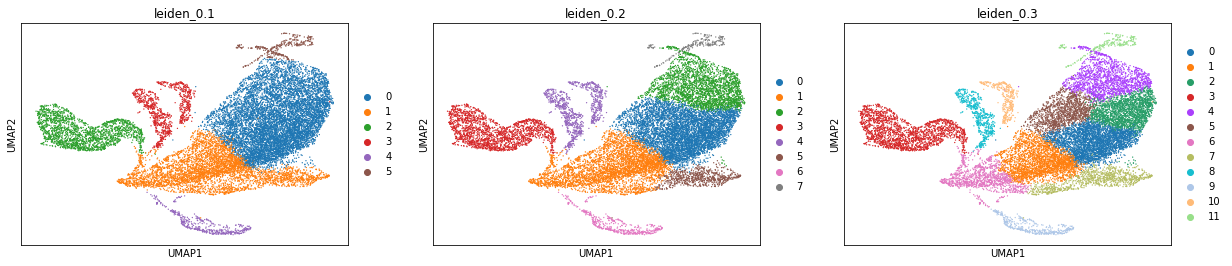

In [138]:
#trying leiden
sc.tl.leiden(brain_data_overlap, resolution = 0.1, key_added = "leiden_0.1")
sc.tl.leiden(brain_data_overlap, resolution = 0.2, key_added = "leiden_0.2")
sc.tl.leiden(brain_data_overlap, resolution = 0.3, key_added = "leiden_0.3")

sc.pl.umap(brain_data_overlap, color=['leiden_0.1', 'leiden_0.2', 'leiden_0.3'])

astrocyte


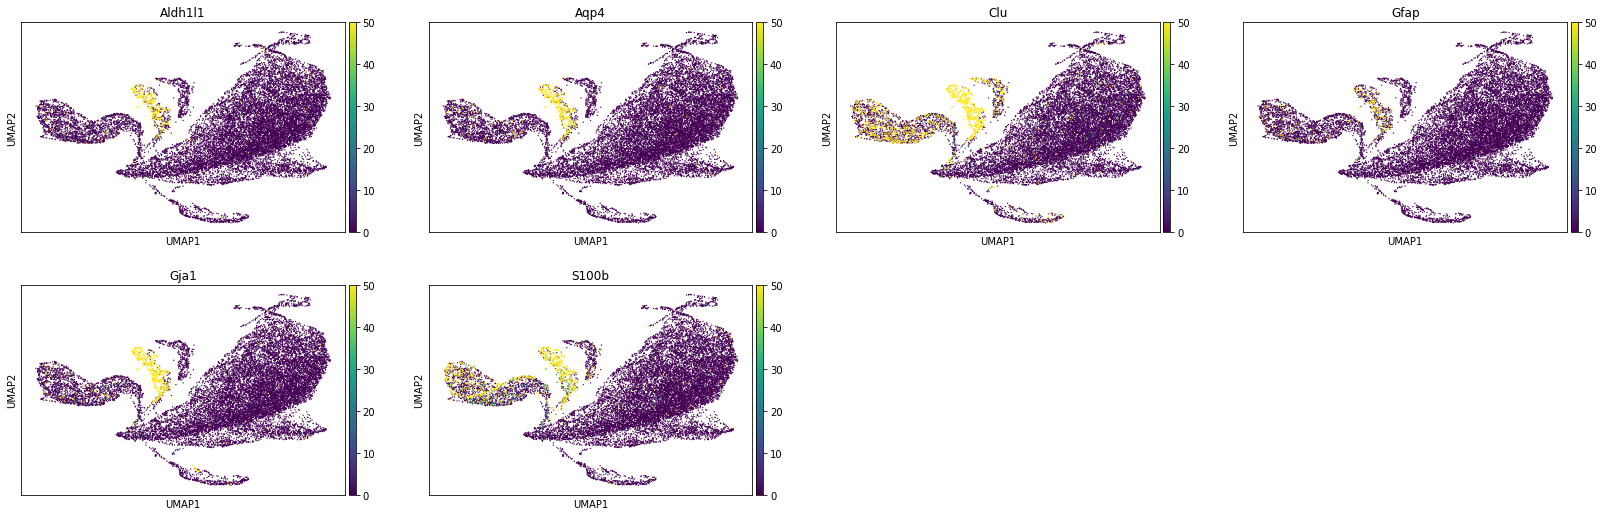

brain pericyte


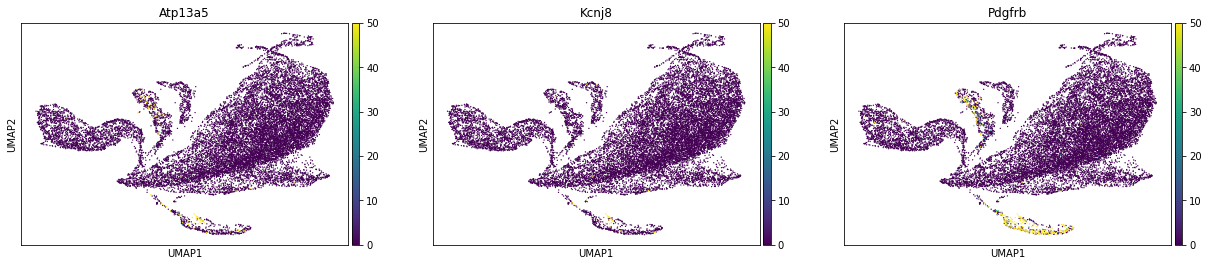

macrophage


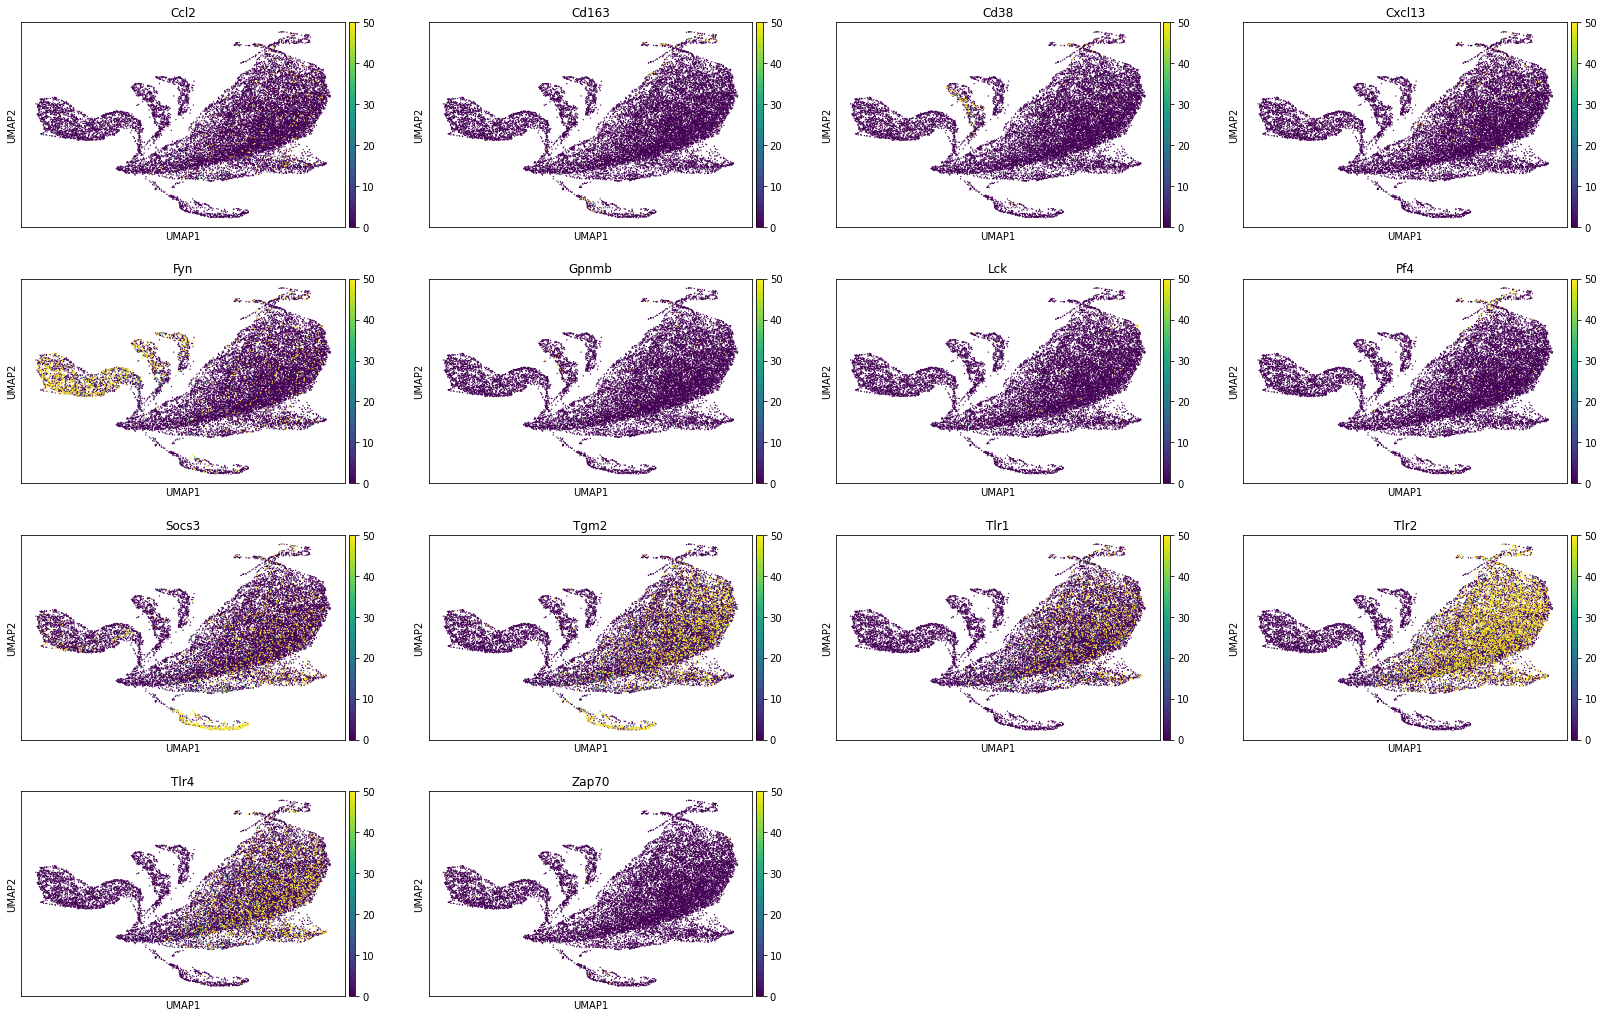

microglial cell


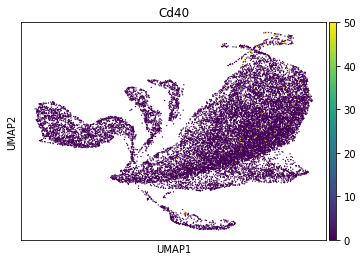

neuron


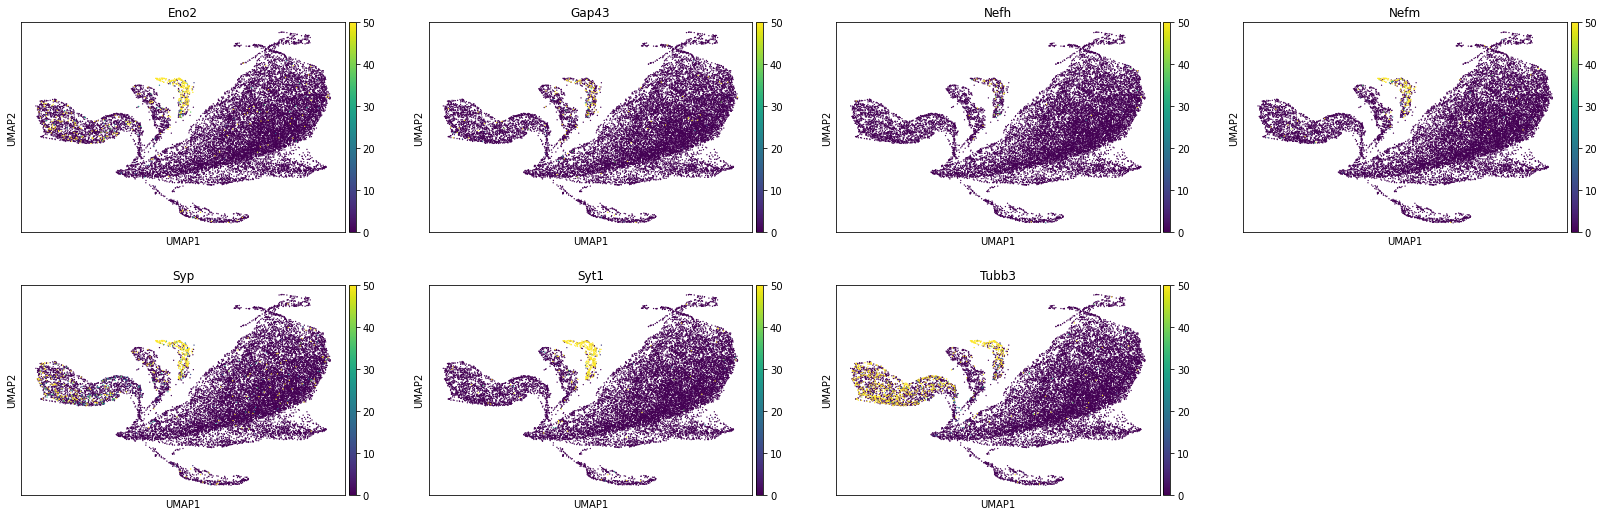

endothelial


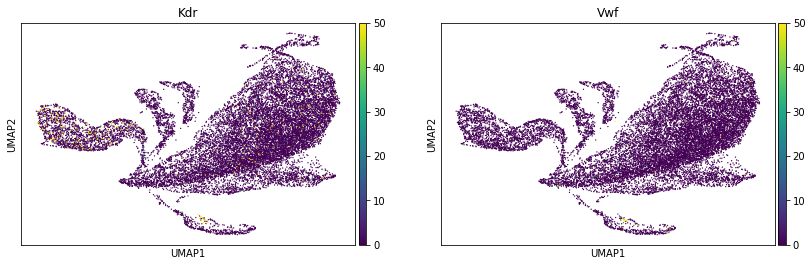

oligodendrocyte


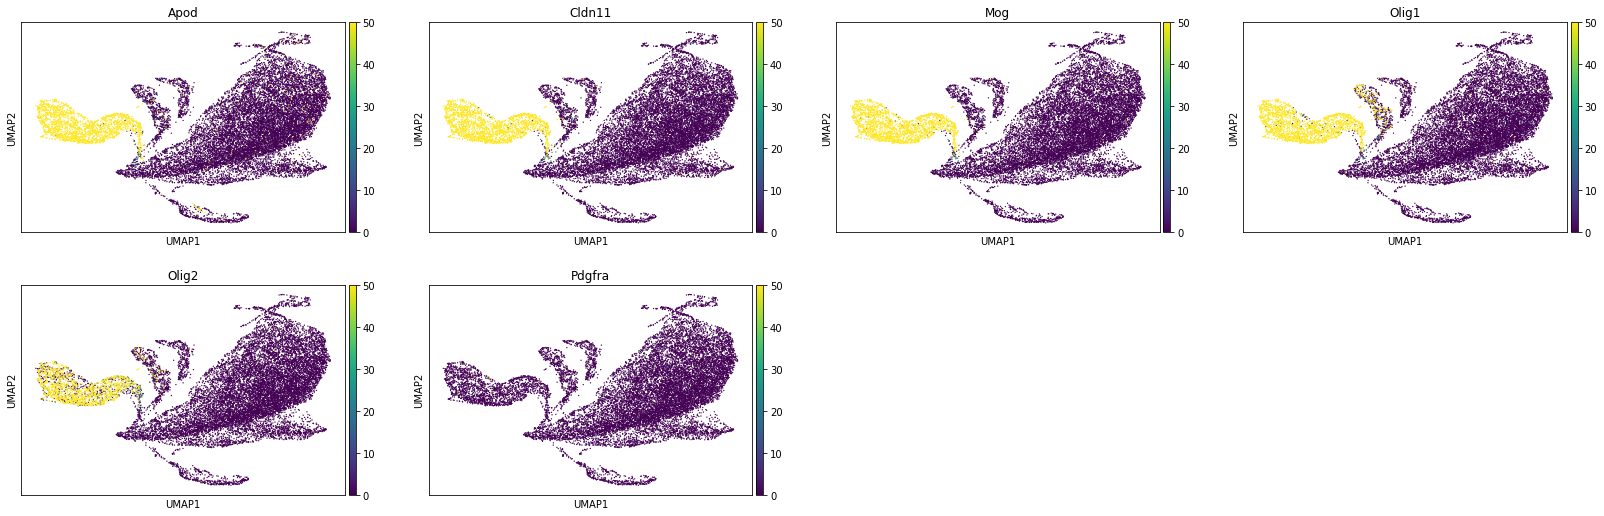

In [130]:
# For the TMS dataset - the cell markers that are used for each cell type
brain_data_gene_filtered = pd.DataFrame(brain_data_overlap.var_names)
brain_data_gene_filtered.rename(columns = {'index':'Gene'}, inplace = True)
for i in enumerate(cell_markers.columns):
    print(i[1])
    markers = pd.DataFrame(cell_markers[i[1]].dropna())
    markers = markers.rename(columns={i[1]: 'Gene'})
    markers_ = brain_data_gene_filtered.merge(markers, how = 'inner', on='Gene') # only keep the markers that are present in the filtered matrix of counts
    sc.pl.umap(brain_data_overlap, color = markers_['Gene'].tolist(), vmax =50)

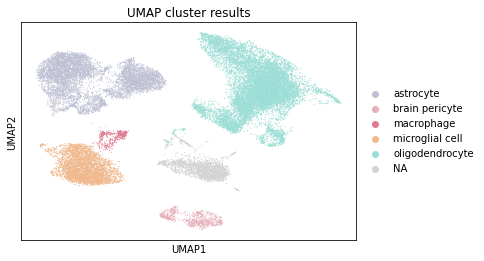

In [124]:
# For the Rubin dataset - replotting only with the overlapping cells
sc.pp.neighbors(rubin_data_overlap, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(rubin_data_overlap)
sc.pl.umap(rubin_data_overlap, color = 'cell_type', title = 'UMAP cluster results')

astrocyte


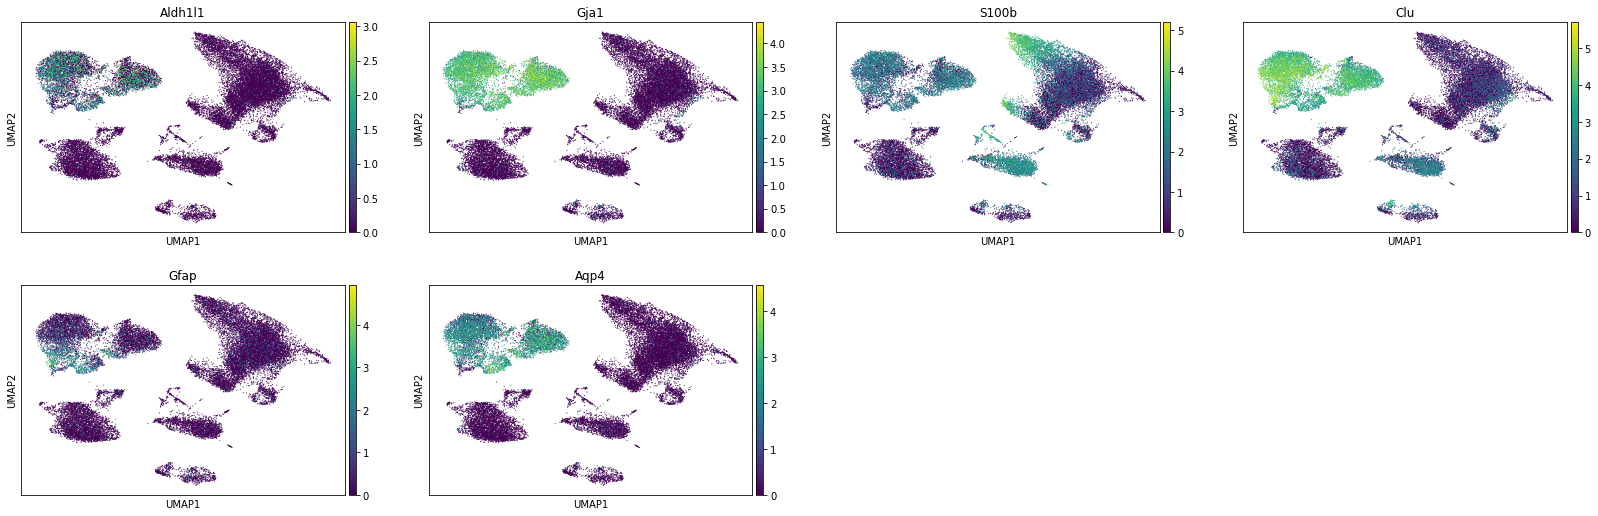

brain pericyte


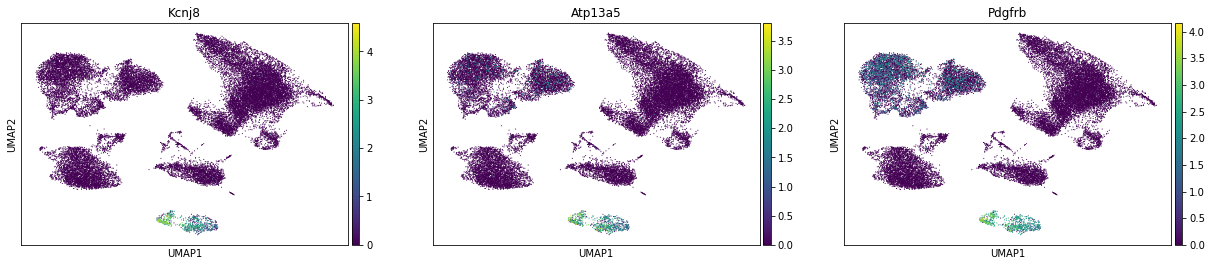

macrophage


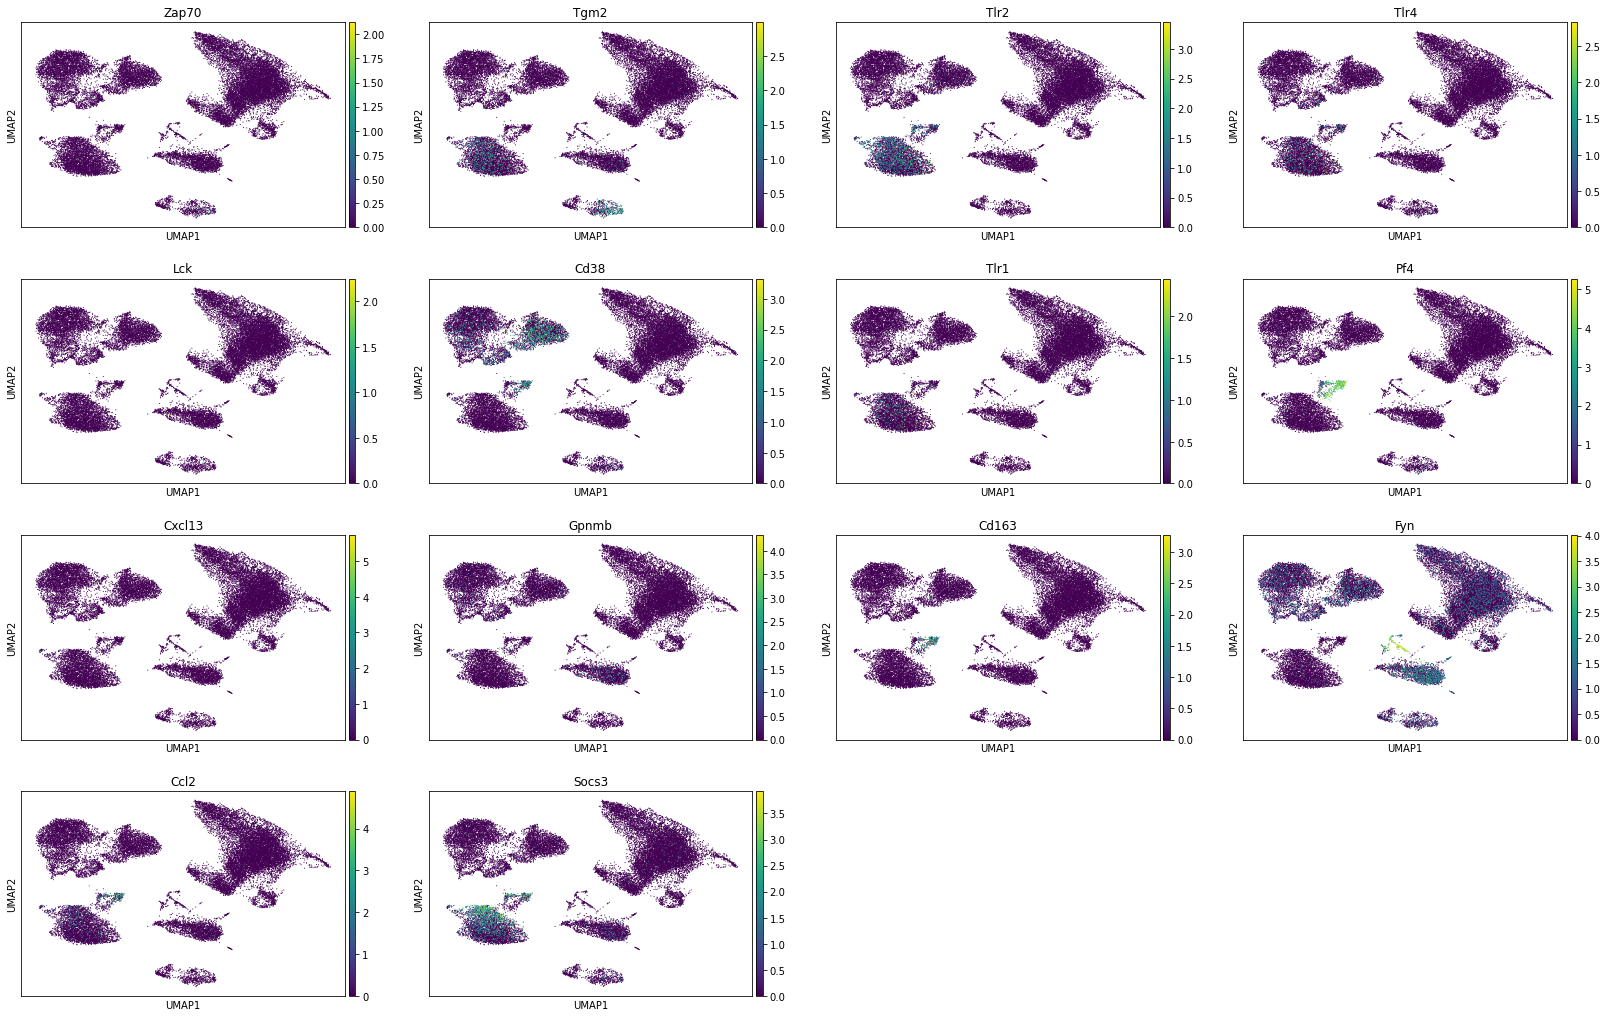

microglial cell


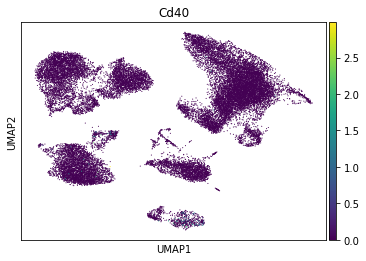

neuron


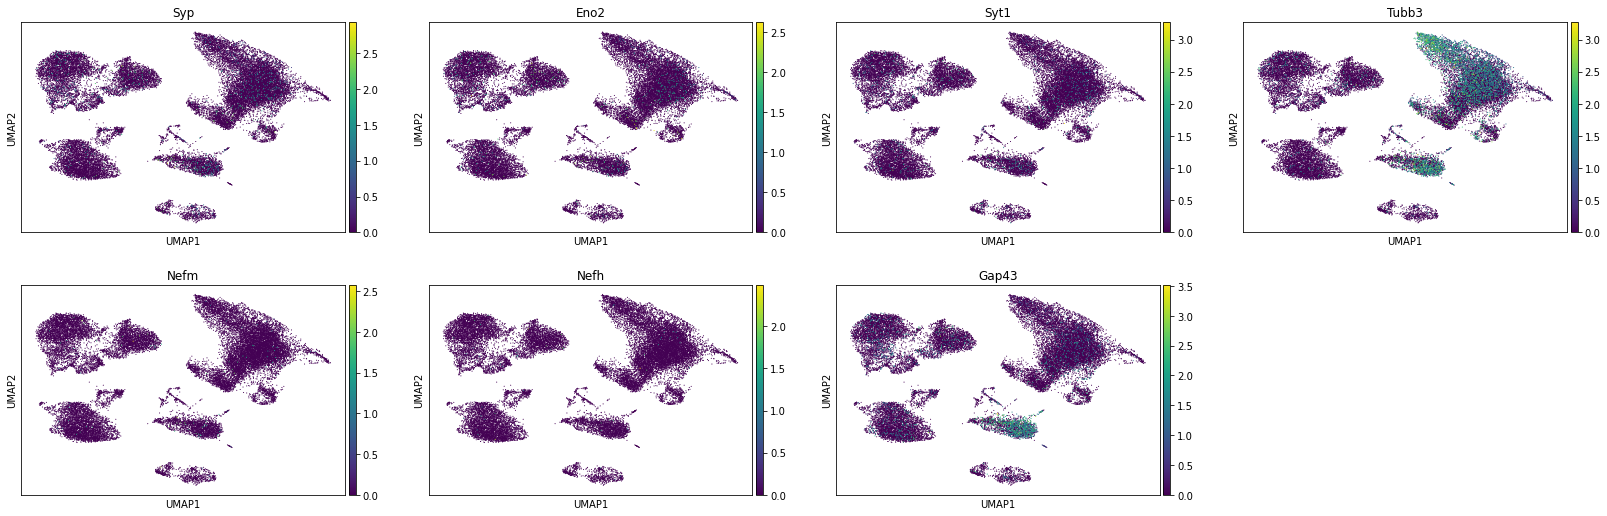

endothelial


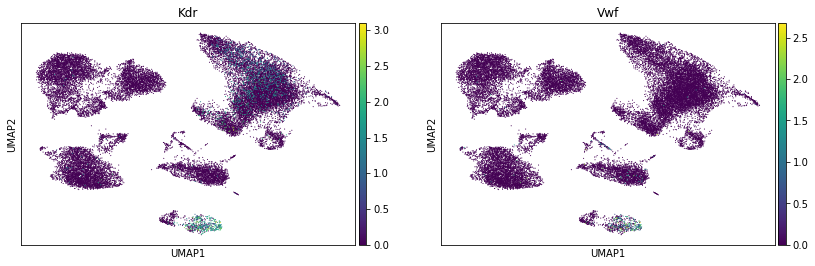

oligodendrocyte


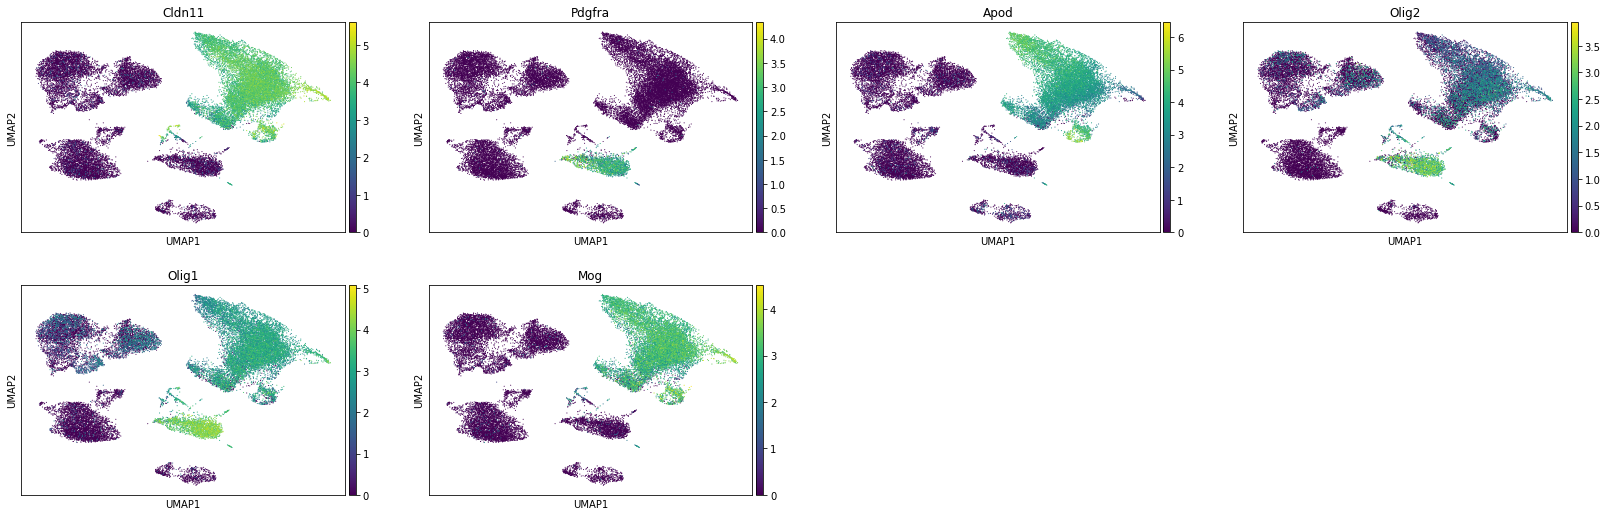

In [125]:
# For the Rubin dataset - the cell markers that are used for each cell type

rubin_data_gene_filtered = pd.DataFrame(rubin_data_overlap.var_names)
rubin_data_gene_filtered.rename(columns = {'gene':'Gene'}, inplace = True)
for i in enumerate(cell_markers.columns):
    print(i[1])
    markers = pd.DataFrame(cell_markers[i[1]].dropna())
    markers = markers.rename(columns={i[1]: 'Gene'})
    markers_ = rubin_data_gene_filtered.merge(markers, how = 'inner', on='Gene') # only keep the markers that are present in the filtered matrix of counts
    sc.pl.umap(rubin_data_overlap, color = markers_['Gene'].tolist())

In [126]:
def plot_genes(cl):
# sc.pp.filter_genes(cl, min_cells=0.1*(counts.n_vars)) 
# we want to get rid of anything with low abundance or low variance: just remove the bottom 10% of out genes since this is a single cell type
    sc.tl.rank_genes_groups(cl, 'age', method='wilcoxon', key_added ="wilcoxon")
    sc.pl.rank_genes_groups(cl, n_genes=10, sharey=False, key="wilcoxon")
    sc.pl.rank_genes_groups_violin(cl, n_genes=10, key="wilcoxon")

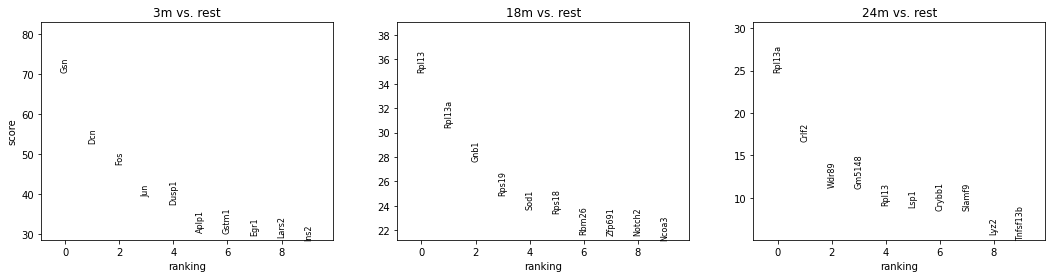

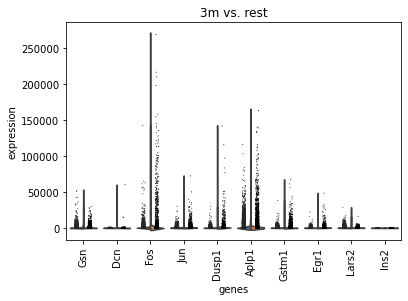

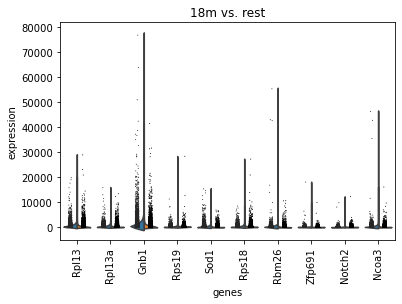

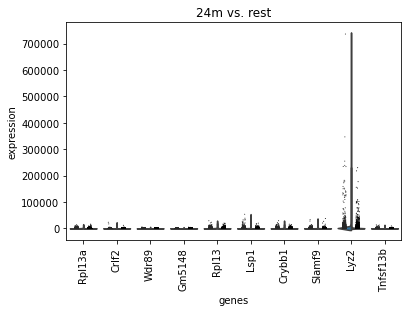

In [127]:
plot_genes(brain_data_overlap)

In [128]:
def plot_genes_rubin(cl):
# sc.pp.filter_genes(cl, min_cells=0.1*(counts.n_vars)) 
# we want to get rid of anything with low abundance or low variance: just remove the bottom 10% of out genes since this is a single cell type
    sc.tl.rank_genes_groups(cl, 'cell_type_by_age', method='wilcoxon', key_added ="wilcoxon")
    sc.pl.rank_genes_groups(cl, n_genes=10, sharey=False, key="wilcoxon")
    sc.pl.rank_genes_groups_violin(cl, n_genes=10, key="wilcoxon")

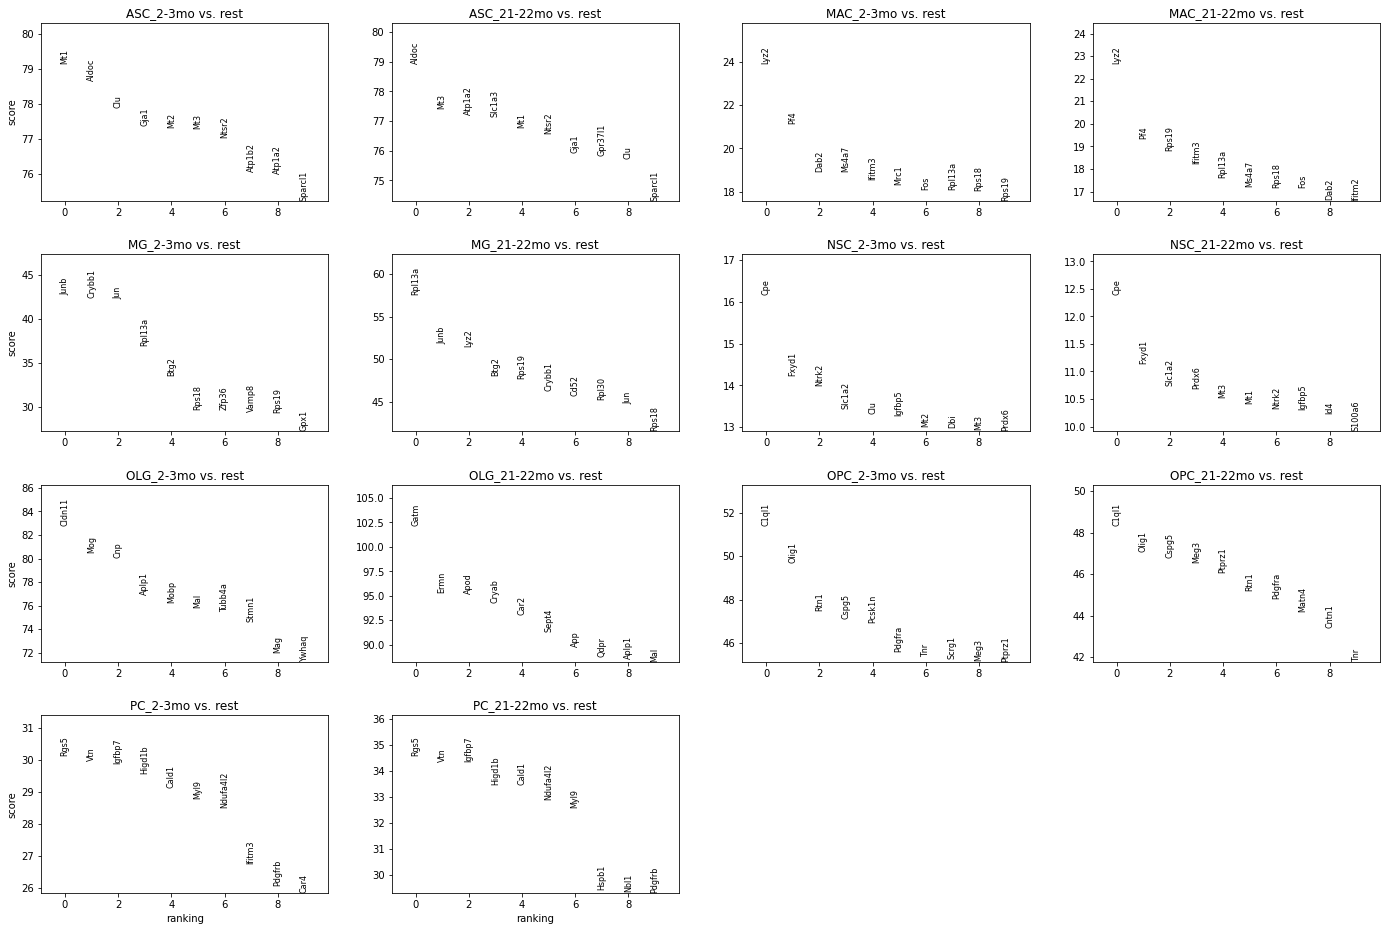

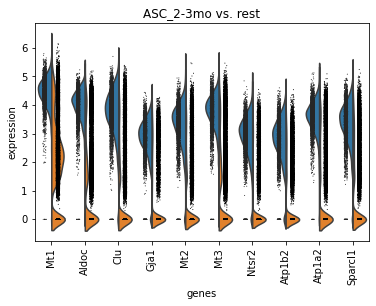

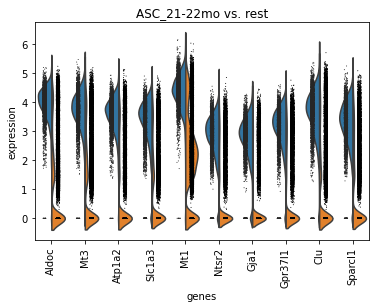

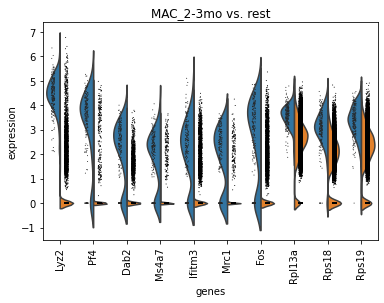

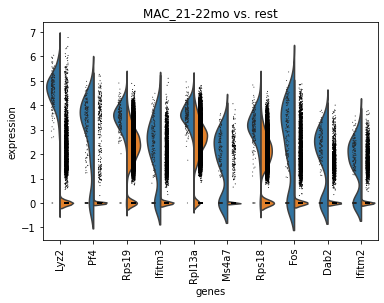

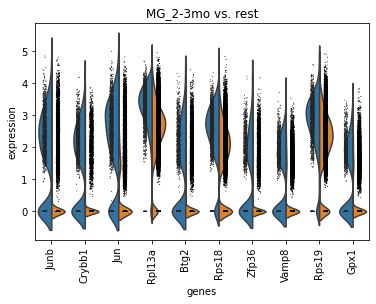

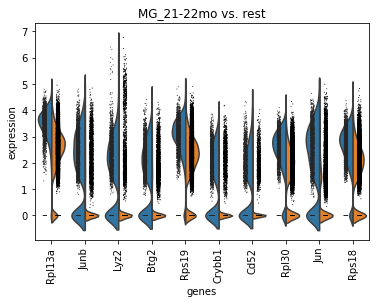

KeyboardInterrupt: 

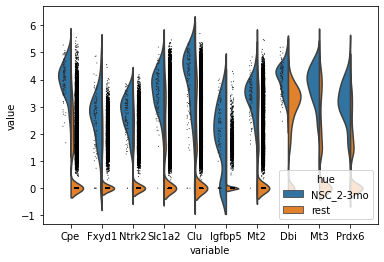

In [129]:
plot_genes_rubin(rubin_data_overlap)

In [ ]:
#subsetting datasets by age group
brain_3 = brain_data_overlap[brain_data_overlap.obs["age"] == "3m"]
brain_18 = brain_data_overlap[brain_data_overlap.obs["age"] == "18m"]
brain_24 = brain_data_overlap[brain_data_overlap.obs["age"] == "24m"]

rubin_young_2_3 = rubin_data_overlap[rubin_data_overlap.obs["all_cells_by_age"] == '2-3mo']
rubin_old_21_22 = rubin_data_overlap[rubin_data_overlap.obs["all_cells_by_age"] == '21-22mo']

#concat AnnData objects https://anndata.readthedocs.io/en/latest/concatenation.html#:~:text=With%20concat()%20%2C%20AnnData%20objects,elements%20in%20an%20ordered%20way.
adatas_young = {
    "young_TMS": brain_3
    ,
    "young_LR": rubin_young_2_3
    ,
}
ad.concat(adatas_young, label="dataset").obs

#concat AnnData objects https://anndata.readthedocs.io/en/latest/concatenation.html#:~:text=With%20concat()%20%2C%20AnnData%20objects,elements%20in%20an%20ordered%20way.
adatas_old = {
    "old_TMS": brain_24
    ,
    "old_LR": rubin_old_21_22
    ,
}
ad.concat(adatas_old, label="dataset").obs

#concat AnnData objects https://anndata.readthedocs.io/en/latest/concatenation.html#:~:text=With%20concat()%20%2C%20AnnData%20objects,elements%20in%20an%20ordered%20way.
adatas_mixed = {
    "old_TMS": brain_24, 
    "mid_TMS": brain_18,
    "old_LR": rubin_old_21_22
    ,
}
ad.concat(adatas_mixed, label="dataset").obs


In [ ]:
#concatenated young brain 2-3 month datasets 
new_young = ad.concat(adatas_young, label="dataset")

#concatenated old brain 24 and 21/22 month datasets 
new_old = ad.concat(adatas_old, label="dataset")

#concatenated old brian 18, 24, and 21/22 month datasets !
new_mix = ad.concat(adatas_mixed, label='dataset')

In [ ]:
#Visualizing concatenation
sc.pp.neighbors(new_young, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(new_young)
sc.pl.umap(new_young, color = 'dataset', title = 'UMAP cluster results for combined young mice')

In [ ]:
#Visualizing concatenation
sc.pp.neighbors(new_old, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(new_old)
sc.pl.umap(new_old, color = 'dataset', title = 'UMAP cluster results for combined old mice')

In [ ]:
#Visualizing concatenation
sc.pp.neighbors(new_mix, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(new_mix)
sc.pl.umap(new_mix, color = 'dataset', title = 'UMAP cluster results for combined old mice')

In [ ]:
#batch correction
# create a new object with lognormalized counts
adata_combat_young = sc.AnnData(X=new_young.X, var=new_young.var, obs = new_young.obs)

# run combat
sc.pp.combat(adata_combat_young, key='dataset')

In [ ]:
#visualizing batch correction
sc.pp.neighbors(adata_combat_young, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(adata_combat_young)
sc.pl.umap(adata_combat_young, color = 'dataset', title = 'BATCH CORRECTED: UMAP cluster results for combined young mice ')

In [ ]:
#batch correction
# create a new object with lognormalized counts
adata_combat_mix = sc.AnnData(X=new_mix.X, var=new_mix.var, obs = new_mix.obs)

# run combat
sc.pp.combat(adata_combat_mix, key='dataset')

In [ ]:
#visualizing batch correction
sc.pp.neighbors(adata_combat_mix, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(adata_combat_mix)
sc.pl.umap(adata_combat_mix, color = 'dataset', title = 'BATCH CORRECTED: UMAP cluster results for combined old mice' )

In [ ]:
#batch correction
# create a new object with lognormalized counts
adata_combat_old = sc.AnnData(X=new_old.X, var=new_old.var, obs = new_old.obs)

# run combat
sc.pp.combat(adata_combat_old, key='dataset')

In [ ]:
#visualizing batch correction
sc.pp.neighbors(adata_combat_old, n_neighbors=5, n_pcs=50) # calculate the neighbors
sc.tl.umap(adata_combat_old)
sc.pl.umap(adata_combat_old, color = 'dataset', title = 'BATCH CORRECTED: UMAP cluster results for combined old mice')

In [ ]:
sc.tl.diffmap(new_young)

In [ ]:
new_young

In [ ]:
sc.pp.neighbors(new_young, n_neighbors=7, n_pcs=50) # calculate the neighbors
sc.tl.umap(new_young)
sc.pl.umap(new_young, color = 'dataset', title = 'UMAP cluster results for combined young mice')

In [ ]:
rubin_data_overlap